This worksheet is used to create a spinup dataset for Nome/Seward Pen.

This is done to generate extremely smooth data that is "typical" of the Seward Pen.  Air temp and incoming shortwave radiation data is daily averages over 10 years of data (i.e. average all Jan 1s, all Jan 2s, etc through the year), then smoothed significantly.  Precip is assumed constant throughout the year, and is assigned to snow or rain based on air temp.  Relative humidity, incoming longwave, and windspeed are all constant as annual averages.

* We need updated shortwave incoming radiation!
* What is the wind speed reference height?

*author: Ethan Coon*

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

# from $ATS_SRC_DIR/tools/utils
import sys,os
try:
    sys.path.append(os.path.join(os.environ["ATS_SRC_DIR"],"tools","utils"))
except KeyError:
    pass    
import plot_met

In [2]:
d = h5py.File("10yr-Nome_data.h5",'r')

In [3]:
d.keys()

[u'air temperature [K]',
 u'incoming longwave radiation [W m^-2]',
 u'incoming shortwave radiation [W m^-2]',
 u'precipitation rain [m s^-1]',
 u'precipitation snow [m SWE s^-1]',
 u'relative humidity [-]',
 u'time [s]',
 u'wind speed [m s^-1]']

[      0.   86400.  172800.  259200.  345600.  432000.  518400.  604800.
  691200.  777600.]
<HDF5 dataset "time [s]": shape (3650,), type "<f8">
<HDF5 dataset "air temperature [K]": shape (3650,), type "<f8">
<HDF5 dataset "incoming longwave radiation [W m^-2]": shape (3650,), type "<f8">
<HDF5 dataset "incoming shortwave radiation [W m^-2]": shape (3650,), type "<f8">
<HDF5 dataset "precipitation rain [m s^-1]": shape (3650,), type "<f8">
<HDF5 dataset "precipitation snow [m SWE s^-1]": shape (3650,), type "<f8">
<HDF5 dataset "relative humidity [-]": shape (3650,), type "<f8">
<HDF5 dataset "time [s]": shape (3650,), type "<f8">
<HDF5 dataset "wind speed [m s^-1]": shape (3650,), type "<f8">


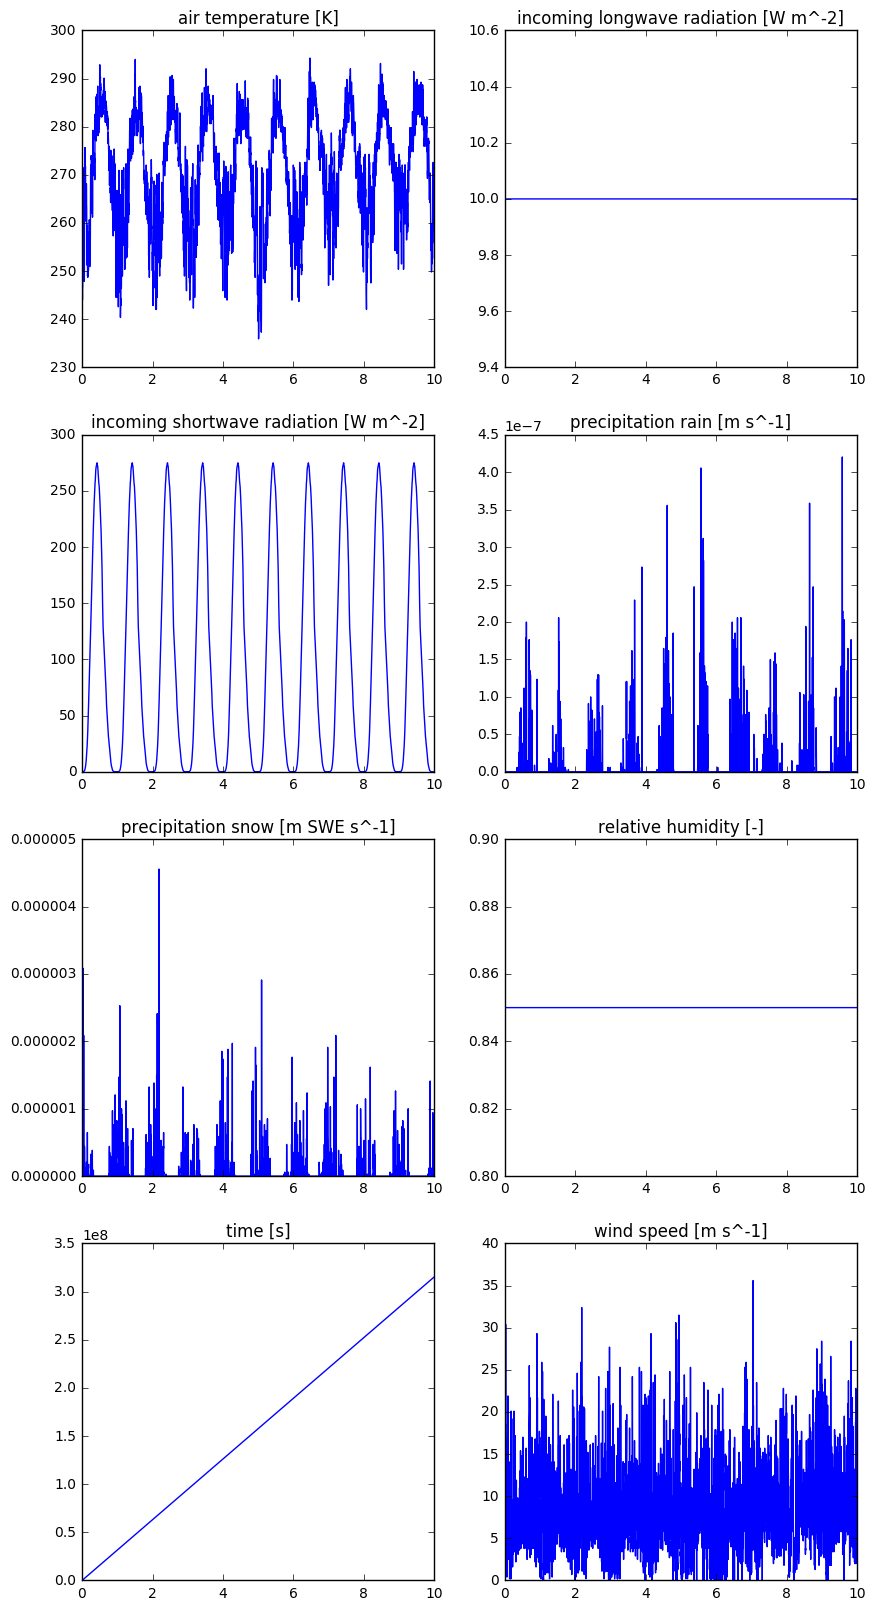

In [4]:
fax = plt.subplots(4,2,figsize=(10,20))
ax = fax[1].ravel()

print d['time [s]'][0:10]
print d['time [s]']
time = d['time [s]'][:]


for i,k in enumerate([k for k in d.keys() if not "reference height" in k]):
    print d[k]
    ax[i].plot(time/86400.0/365.0, d[k][:], 'b')
    ax[i].set_title(k)

plt.show()

In [1]:
ma_wind_speed = d["wind speed [m s^-1]"][:].mean()
print ma_wind_speed

ma_wind_speed = 8.5


NameError: name 'd' is not defined

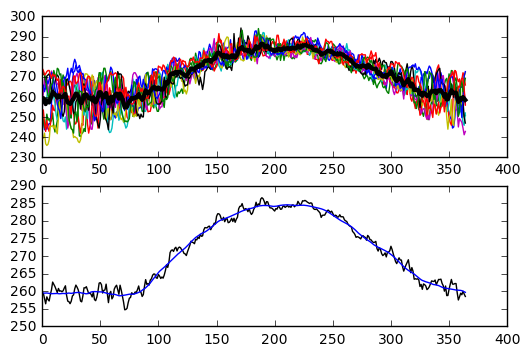

In [6]:
fax = plt.subplots(2,1)

air_temp_raw = d['air temperature [K]'][:]
air_temp_raw = air_temp_raw.reshape((10,365)).transpose()
for i in range(10):
    fax[1][0].plot(air_temp_raw[:,i])


air_temp = air_temp_raw.mean(axis=1)
fax[1][0].plot(air_temp,'k',linewidth=3)

import scipy.signal
air_temp_sm = scipy.signal.savgol_filter(air_temp, 61, 2, mode='wrap')
fax[1][1].plot(air_temp, 'k')
fax[1][1].plot(air_temp_sm, 'b')

plt.show()

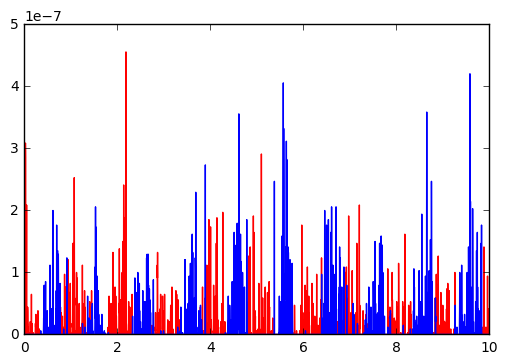

In [7]:
plt.plot(d['time [s]'][:]/86400./365, d['precipitation snow [m SWE s^-1]'][:]/10.0, 'r')
plt.plot(d['time [s]'][:]/86400./365, d['precipitation rain [m s^-1]'][:], 'b')
plt.show()

ma_precip = (d['precipitation snow [m SWE s^-1]'][:]/10.0 + d['precipitation rain [m s^-1]'][:]).mean()

snow = np.where(air_temp_sm < 273.15, ma_precip, 0)
rain = np.where(air_temp_sm >= 273.15, ma_precip, 0)


In [11]:
# organize data into 100 year cycle and save to file
time100 = np.arange(0, 86400.0*365*100, 86400.0)
air_temp100 = np.concatenate([air_temp_sm,]*100)
snow100 = np.concatenate([snow,]*100)
rain100 = np.concatenate([rain,]*100)
qSW100 = np.concatenate([d["incoming shortwave radiation [W m^-2]"][0:365],]*100)
qLW100 = np.concatenate([d["incoming longwave radiation [W m^-2]"][0:365],]*100)
rh100 = np.concatenate([d["relative humidity [-]"][0:365],]*100)
wind_speed100 = ma_wind_speed * np.ones(time100.shape,'d')

assert time100.shape == (36500,)
assert air_temp100.shape == (36500,)
assert snow100.shape == (36500,)
assert rain100.shape == (36500,)
assert qSW100.shape == (36500,)
assert qLW100.shape == (36500,)
assert rh100.shape == (36500,)
assert wind_speed100.shape == (36500,)

with h5py.File("spinup-100yr.h5",'w') as out:
    out.create_dataset("time [s]", data=time100)
    out.create_dataset("air temperature [K]", data=air_temp100)
    out.create_dataset("relative humidity [-]", data=rh100)
    out.create_dataset("precipitation rain [m s^-1]", data=rain100)
    out.create_dataset("precipitation snow [m SWE s^-1]", data=snow100)
    out.create_dataset("incoming shortwave radiation [W m^-2]", data=qSW100)
    out.create_dataset("incoming longwave radiation [W m^-2]", data=qLW100)
    out.create_dataset("wind speed [m s^-1]", data=wind_speed100)
    out.attrs.create("wind speed reference height [m]", data=0.0) # fix me
    